# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Thursday, March 5, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1WBJStVQnAlrC05dhAUKTqbZEjyAN1Fkq/view?usp=sharing

In [0]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [0]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [0]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [4]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [5]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


In [6]:
#Report max, min, and avg value
print("The maximum value of age is {}".format(df['age'].max()))
print("The minimum value of age is {}".format(df['age'].min()))
print("The average value of age is {}".format(df['age'].mean()))

print("\nThe maximum value of yredu is {}".format(df['yredu'].max()))
print("The minimum value of yredu is {}".format(df['yredu'].min()))
print("The average value of yredu is {}".format(df['yredu'].mean()))

print("\nThe maximum value of capgain is {}".format(df['capgain'].max()))
print("The minimum value of capgain is {}".format(df['capgain'].min()))
print("The average value of capgain is {}".format(df['capgain'].mean()))

print("\nThe maximum value of caploss is {}".format(df['caploss'].max()))
print("The minimum value of caploss is {}".format(df['caploss'].min()))
print("The average value of caploss is {}".format(df['caploss'].mean()))

print("\nThe maximum value of workhr is {}".format(df['workhr'].max()))
print("The minimum value of workhr is {}".format(df['workhr'].min()))
print("The average value of workhr is {}".format(df['workhr'].mean()))

The maximum value of age is 90
The minimum value of age is 17
The average value of age is 38.58164675532078

The maximum value of yredu is 16
The minimum value of yredu is 1
The average value of yredu is 10.0806793403151

The maximum value of capgain is 99999
The minimum value of capgain is 0
The average value of capgain is 1077.6488437087312

The maximum value of caploss is 4356
The minimum value of caploss is 0
The average value of caploss is 87.303829734959

The maximum value of workhr is 99
The minimum value of workhr is 1
The average value of workhr is 40.437455852092995


In [7]:
df["age"] = (df["age"]-df["age"].min())/(df["age"].max()-df["age"].min())
print("The normalized average value of age is {}".format(df['age'].mean()))

df["yredu"] = (df["yredu"]-df["yredu"].min())/(df["yredu"].max()-df["yredu"].min())
print("The normalized average value of yredu is {}".format(df['yredu'].mean()))

df["capgain"] = (df["capgain"]-df["capgain"].min())/(df["capgain"].max()-df["capgain"].min())
print("The normalized average value of capgain is {}".format(df['capgain'].mean()))

df["caploss"] = (df["caploss"]-df["caploss"].min())/(df["caploss"].max()-df["caploss"].min())
print("The normalized average value of caploss is {}".format(df['caploss'].mean()))

df["workhr"] = (df["workhr"]-df["workhr"].min())/(df["workhr"].max()-df["workhr"].min())
print("The normalized average value of workhr is {}".format(df['workhr'].mean()))

The normalized average value of age is 0.2956389966482344
The normalized average value of yredu is 0.6053786226875428
The normalized average value of capgain is 0.010776596203049367
The normalized average value of caploss is 0.02004220150022017
The normalized average value of workhr is 0.4024230188989772


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [8]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,0.301370,0.800000,0.02174,0.0,0.397959
1,0.452055,0.800000,0.00000,0.0,0.122449
2,0.287671,0.533333,0.00000,0.0,0.397959


Numpy works nicely with pandas, like below:

In [9]:
np.sum(subdf["caploss"])

652.5941230486685

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [10]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

21790

In [11]:
male_percent = sum(df["sex"] == " Male")/df.shape[0]
print("The male percentage is {} %".format(male_percent*100))
female_percent = sum(df["sex"] == " Female")/df.shape[0]
print("The female percentage is {} %".format(female_percent*100))

The male percentage is 66.92054912318419 %
The female percentage is 33.07945087681583 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [0]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [0]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [14]:
print("{} records contained missing features.".format(df_with_missing.shape[0]) )
print("we removed {}% of records.".format(df_with_missing.shape[0]/df.shape[0]*100) )

1843 records contained missing features.
we removed 5.660145572924664% of records.


**Answer:**

**1843 records contained missing features.
We removed 5.66% of records.**

### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [15]:
set0 = set(df_not_missing['work'])
print(set0)

{' Private', ' Self-emp-not-inc', ' Local-gov', ' Self-emp-inc', ' State-gov', ' Federal-gov', ' Without-pay'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [0]:
data = pd.get_dummies(df_not_missing)

In [17]:
data[:20]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.021740,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
5,0.273973,0.866667,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
6,0.438356,0.266667,0.000000,0.0,0.153061,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
7,0.479452,0.533333,0.000000,0.0,0.448980,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
8,0.191781,0.866667,0.140841,0.0,0.500000,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
9,0.342466,0.800000,0.051781,0.0,0.397959,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [18]:
print("There are {} columns in data.".format(data.shape[1]))

There are 57 columns in data.


**Answer:**

The number is equal to numbers of the types of every column with string value, plus the number of columns with numerical values in orginal df. What the get_dummies function does is to use categorical value(numerical code) to represent the string value.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [0]:
datanp = data.values.astype(np.float32)

In [0]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)



def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful

    a = onehot.tolist()
    max_index = a.index(onehot.max())
    return cat_values[feature][max_index]
    

In [21]:
#Test if the function can work properly
print(get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work"))
print(get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work"))

State-gov
Private


In [0]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }


### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [64]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
copy=np.copy(data).tolist()

train_dataset = []
val_dataset = []
test_dataset= []
train_size = 0.7*len(datanp)
val_size = 0.15*len(datanp)
test_size = 0.15*len(datanp)


while len(copy)>=1:
  if(len(train_dataset)<=train_size):
    random_index=random.randrange(0,len(copy))
    train_dataset.append(copy.pop(random_index))
  if(len(val_dataset)<=val_size):
    random_index=random.randrange(0,len(copy))
    val_dataset.append(copy.pop(random_index))
  if(len(test_dataset)<=test_size):
    random_index=random.randrange(0,len(copy))
    test_dataset.append(copy.pop(random_index))
  

train_dataset=np.array(train_dataset)
val_dataset=np.array(val_dataset)
test_dataset=np.array(test_dataset)


print(train_dataset.shape)
print(val_dataset.shape)
print(test_dataset.shape)

(21502, 57)
(4608, 57)
(4608, 57)


In [24]:
np.random.seed(50)
train_frame, val_frame, test_frame = np.split(data.sample(frac=1), [int(.7*len(data)), int(.85*len(data))])
test_frame[0:1]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
30728,0.657534,0.8,0.067231,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


**Answer:**

There are **21502 items in training dataset and 4608 items in both validation and testing dateset**

## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [0]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 20), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(20, 12)
        )
        self.decoder = nn.Sequential(
            nn.Linear(12, 20), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(20, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

**Answer:**

Because the input data is normalized to the range [0, 1], we should use sigmoid functon to transform our output to range [0, 1] as well.

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [0]:
import matplotlib.pyplot as plt
def cal_loss(model, loader, criterion):
    total_loss = 0.0
    for i, data in enumerate(loader, 0):
        datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
        recon = model(datam)
        loss = criterion(recon.double(), data)
        total_loss += loss
    loss = float(total_loss) / (i + 1)
    return loss


def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses, iters, train_acc, val_acc = [], [], [], [], []

    n=0
    
    print("Training start!")
    for epoch in range(num_epochs):
        for data in train_loader:
            # print(data)
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            # print(datam)
            recon = model(datam)
            loss = criterion(recon.double(), data)
            n += 1
            if n%(80*num_epochs)==0:
              # train_losses.append(cal_loss(model, train_loader, criterion))
              train_losses.append(loss)
              val_losses.append(cal_loss(model, valid_loader, criterion))
              iters.append(n)        
              train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
              val_acc.append(get_accuracy(model, valid_loader))  # compute validation accuracy
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
    plt.title("Training vs Validation Loss")
    plt.plot(iters, train_losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()        
    
    plt.title("Training vs Validation Accuracy")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final training accuacy is {}".format(get_accuracy(model, train_loader)))
    print("Final validation accuacy is {}".format(get_accuracy(model, valid_loader)))


### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [0]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

In [28]:

#Build data loader from data set
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=1, shuffle=True)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

672
144
144


Training start!


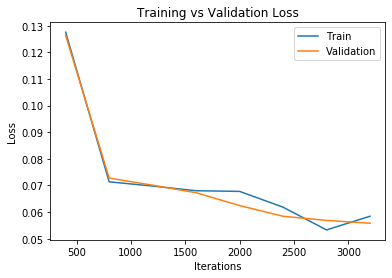

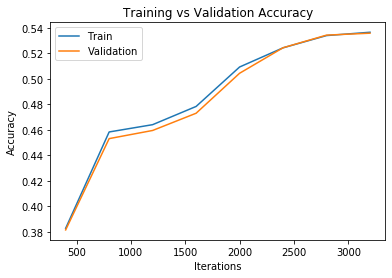

Final training accuacy is 0.537756177719902
Final validation accuacy is 0.5384114583333334


In [54]:
a = AutoEncoder()
train(a, train_loader, val_loader)

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

**Answer:**

My initial hyperparameters are: **num_epoch=5, learning_rate=1e-4, layers in autoencoder=2, batch_size=32**

Training start!


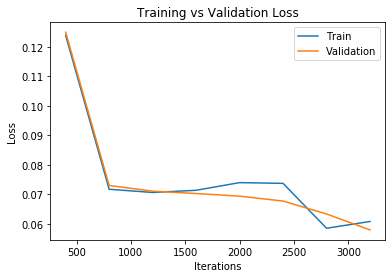

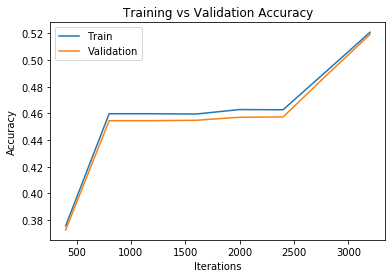

Final training accuacy is 0.5253387281803243
Final validation accuacy is 0.5247395833333334


In [55]:
model0 = AutoEncoder()
train(model0, train_loader, val_loader, num_epochs=5, learning_rate=1e-4) #initial hyperparameters

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

**Answer:**

At first, I decide to increase the num_epochs of model0 and keep the learning rate the same. As shown in the graph above, both training and validation accuracy are increasing. So, I would like to see what the model will perform if I train it with the same training dataset more times. I choose the hyperparameters: **num_epoch=10, learning_rate=1e-4, layers in autoencoder=2, batch_size=32**

Training start!


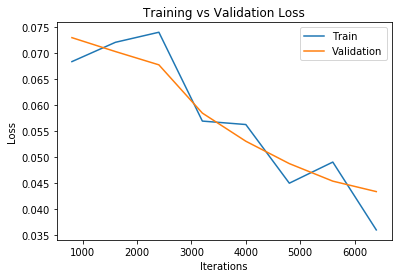

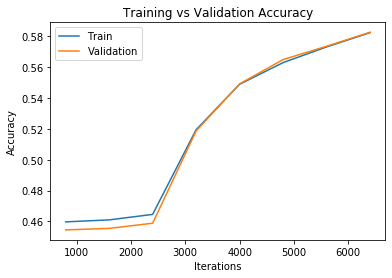

Final training accuacy is 0.5826899823272254
Final validation accuacy is 0.5840205439814815


In [56]:
model1 = AutoEncoder()
train(model1, train_loader, val_loader, num_epochs=10, learning_rate=1e-4)

**Thought Process:**

As shown in the graph above, there isn't a huge improvement in the accuracy. I think maybe the problem is that the learning rate is too small. So I would like to increase the learning rate while keeping the num_epoch the same to see if it can help. I choose the hyperparameters: **num_epoch=10, learning_rate=5e-4, layers in autoencoder=2, batch_size=32**

Training start!


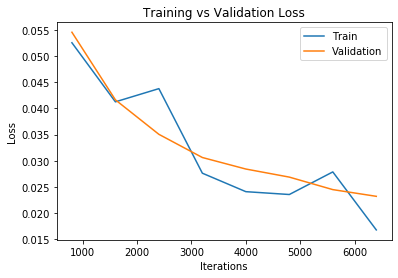

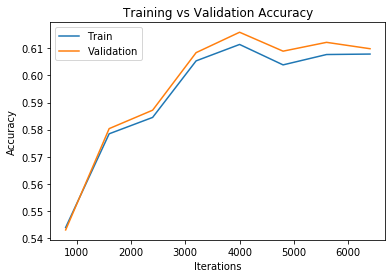

Final training accuacy is 0.6110439338976219
Final validation accuacy is 0.6129918981481481


In [57]:
model2 = AutoEncoder()
train(model2, train_loader, val_loader, num_epochs=10, learning_rate=5e-4)

**Thought Process:**

As shown in the graph above, there is a large improvement in the final training and validation accuracy and they keep remaining apparently the same after some iterations. I think the problem is that the learning rate is still not large enough and make the model stay in a local minimum. So I would like to keep increasing the learning rate and batch_sizewhile keep other hyperparameters the same. I choose the hyperparameters**: num_epoch=10, learning_rate=1e-3, layers in autoencoder=2, batch_size = 64**

Training start!


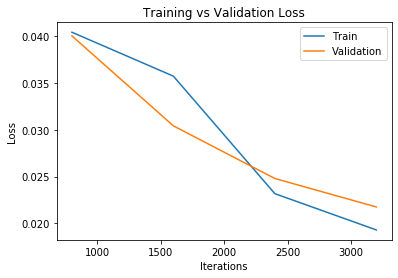

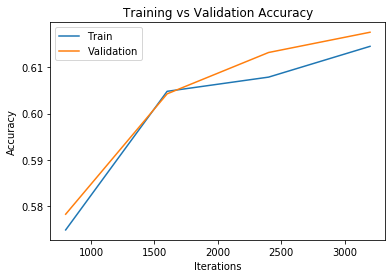

Final training accuacy is 0.6153071032152048
Final validation accuacy is 0.6193214699074074


In [58]:
train_loader3 = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=1, shuffle=True)
val_loader3 = torch.utils.data.DataLoader(val_dataset, batch_size=64, num_workers=1, shuffle=True)

model3 = AutoEncoder()
train(model3, train_loader3, val_loader3, num_epochs=10, learning_rate=1e-3)

**Thought Process:**

As shown in the graph above, there is a improvement in the final training and validation accuracy. So I would like to keep increasing the num_epoch and the learning rate. I choose the hyperparameters: **num_epoch=30, learning_rate=5e-3, layers in autoencoder=2, batch_size=64**

Training start!


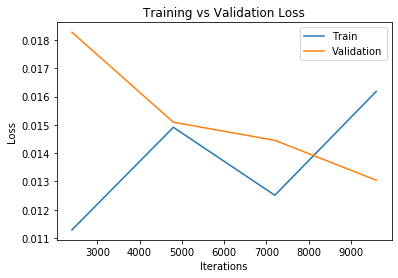

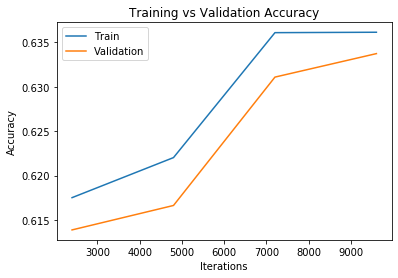

Final training accuacy is 0.632065234241776
Final validation accuacy is 0.6321614583333334


In [87]:
train_loader4 = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=1, shuffle=True)
val_loader4 = torch.utils.data.DataLoader(val_dataset, batch_size=64, num_workers=1, shuffle=True)

model4 = AutoEncoder()
train(model4, train_loader4, val_loader4, num_epochs=30, learning_rate=5e-3)

**Further exaplanation:**

I have also tried changing **the number of layers in the autoencoderr**, hoping that it can help the model better learn the important feature & pattern of the training data. But in fact, it has few effect on improving both the training and validation accuracy (because the change in the number of layers require the change in the code of model structure, I don't show the training graph here).

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [81]:
test_accuracy = get_accuracy(model4, test_loader)
print("The final test accuracy is {}".format(test_accuracy))

The final test accuracy is 0.6445674189814815


**Answer:**

My model test accuracy is about **64.5%**.

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [0]:
def baseline_model_accruracy(data):
    sum = 0;
    for k in cat_index.keys():
        # print(data[k].value_counts().idxmax())
        sum += data[k].value_counts().max()
    return sum/(data.shape[0]*len(cat_index))



In [0]:
b_accr = baseline_model_accruracy(df_not_missing)
print("The baseline model test accuracy is {}".format(b_accr))

**Answer:**

The baseline model test accuracy is **45.92%**.

### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

**Answer:**

My test accuracy is higher than the basline model test accuracy, which means that my model can outperform the baseline model.

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

**Answer:**

Yes. Because thers are some direct relationship between other features and the education level, such as the year of eduction and occupation. But it's also possible for a human to make a wrong prediction.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [0]:
def my_prediction(model, data_loader, feature):
  for item in data_loader: # minibatches
      inp = item.detach().numpy()
      out = model(zero_out_feature(item.clone(), feature)).detach().numpy()
      return get_feature(out[0], feature)

print("My model prediction of this person is "+ my_prediction(model4, test_loader, "edu"))


**Answer:**

My model prediction of this person is **Bachelors**.

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [0]:
def baseline_prediction(data, feature):
    return data[feature].value_counts().idxmax()

print("The baseline model prediction of this person is "+baseline_prediction(df_not_missing, "edu"))

**Answer:**

The baseline model prediction of this person is **HS-grad**.